# Dispatch valuation

**TODO: Tidy up and encapsulate function definitions!**

Routines for dispatch validation comprising
* Evaluation of dispatch per energy carrier against historical one
* Evaluation of imports and exports
* Evaluation of storage operation
* Evaluation of energy not served and scarcity events

## Package imports

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## Electrical bus data
### Read in

In [9]:
path_results = "./model_results/"
file_name = "dispatch_LP_start-2017-01-01_364-days_simple_complete_production.csv"

In [10]:
buses_el = pd.read_csv(path_results + file_name, index_col=0)

### Filter and aggregate
* Filter for Germany
* Split into subsets for generation, export / import and storage

In [11]:
# Filter generation, exports and imports for Germany
bus_DE = buses_el[[col for col in buses_el.columns if "DE" in col]]

In [19]:
# Filter imports and exports and calculate overall and net imports & exports
im_ex_DE = bus_DE[[col for col in bus_DE.columns if "link_" in col]].copy()
im_ex_DE["overall_exports"] = im_ex_DE[[col for col in im_ex_DE if "('DE_link_" in col]].sum(axis=1)
im_ex_DE["overall_imports"] = -im_ex_DE[[col for col in im_ex_DE if "_link_DE')" in col]].sum(axis=1)
im_ex_DE["net_export"] = im_ex_DE["overall_exports"] + im_ex_DE["overall_imports"]
im_ex_DE.index = pd.to_datetime(im_ex_DE.index)

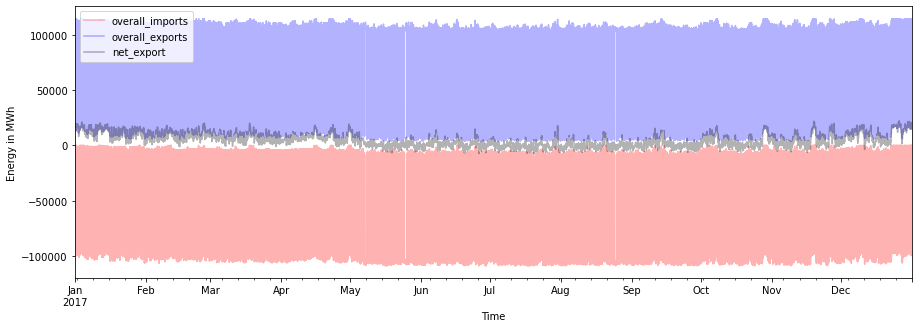

In [72]:
fig, ax = plt.subplots(figsize=(15, 5)) 

im_ex_DE[["overall_imports", "overall_exports", "net_export"]].plot(ax=ax, color=["red", "blue", "black"], alpha=0.3)
ax.set_xlabel("Time")
ax.set_ylabel("Energy in MWh")

plt.show()

In [74]:
storage_DE = bus_DE[[col for col in bus_DE.columns if "storage" in col]]
storage_DE_renamed = storage_DE.rename(columns={
    "(('DE_bus_el', 'DE_storage_el_PHS'), 'flow')": "storage_in",
    "(('DE_storage_el_PHS', 'DE_bus_el'), 'flow')": "storage_out"
})
storage_DE_renamed["storage_in"] *= -1
storage_DE_renamed["net_storage"] = storage_DE_renamed["storage_out"] + storage_DE_renamed["storage_in"]
storage_DE_renamed.index = pd.to_datetime(storage_DE_renamed.index)

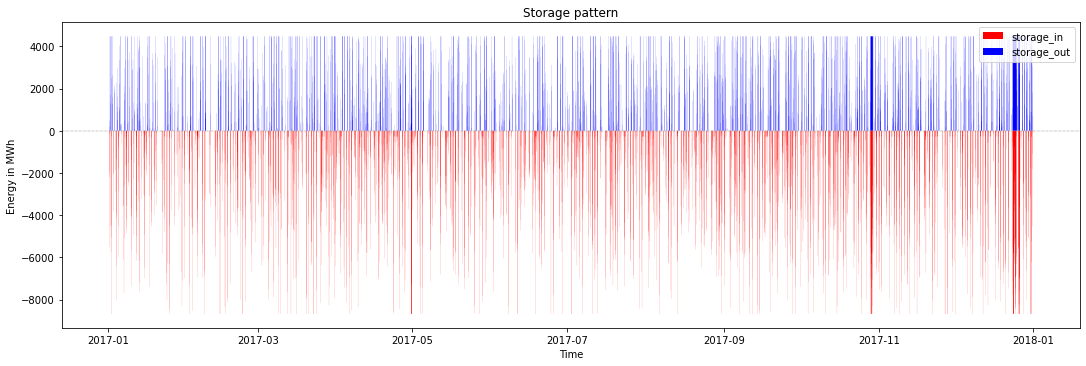

In [84]:
fig, ax = plt.subplots(figsize=(15, 5))    


_ = ax.fill_between(
    storage_DE_renamed.index, 0, storage_DE_renamed.storage_in,
    step='post',
    facecolor='red',
    label="storage_in",
    alpha=1
)
_ = ax.fill_between(
    storage_DE_renamed.index, 0, storage_DE_renamed.storage_out,
    step='post',
    facecolor='blue',
    label="storage_out",
    alpha=1
)

_ = plt.axhline(y=0, color='gray', linestyle='-.', linewidth=.4)
_ = plt.title("Storage pattern")
_ = plt.tight_layout()
ax.set_xlabel("Time")
ax.set_ylabel("Energy in MWh")
_ = plt.legend()

plt.show()

In [89]:
# Aggregate all generation units
power_generation_DE = bus_DE[[
    col for col in bus_DE.columns 
    if col not in im_ex_DE.columns
    and col not in storage_DE.columns
]]

# Drop demand, power prices and shortage
power_generation_DE = power_generation_DE.drop(
    columns=[
        "(('DE_bus_el', 'DE_sink_el_load'), 'flow')", 
        "(('DE_bus_el', 'None'), 'duals')",
        "(('DE_source_el_shortage', 'DE_bus_el'), 'flow')",
    ]
)

power_generation_DE["overall_generation"] = power_generation_DE.sum(axis=1)

In [124]:
fuel_dict = {
    'solarPV': 'Solare Strahlungsenergie',
    'windonshore': 'Windenergie an Land',
    'windoffshore': 'Windenergie auf See',
    'uranium': 'Kernenergie',
    'lignite': 'Braunkohle',
    'otherfossil': 'Andere fossile',
    'hardcoal': 'Steinkohle',
    'waste': 'Abfall',
    'mixedfuels': 'Mehrere fossile',
    'biomass': 'Biomasse',
    'biomassEEG': 'Biomasse',
    'landfillgas': 'Deponiegas',
    'geothermal': 'Geothermie',
    'minegas': 'Grubengas',
    'larga': 'Klärgas',
    'natgas': 'Erdgas',
    'oil': 'Heizöl'
}

In [148]:
# Group outputs by energy carrier
energy_sources_dict = OrderedDict()

for fuel in fuel_dict.keys():
    energy_sources_dict[fuel] = [entry for entry in power_generation_DE.columns.values if fuel in entry]

# Store the aggregated production results per energy source
generation = pd.DataFrame()
for key, val in energy_sources_dict.items():
    generation[key] = power_generation_DE[val].sum(axis = 1)

generation["storage_el_out"] = storage_DE_renamed["storage_out"]

<AxesSubplot:>

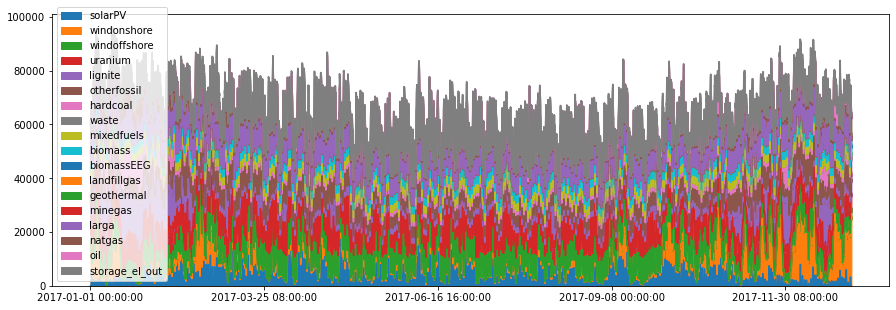

In [147]:
fig, ax = plt.subplots(figsize=(15, 5))
generation.plot(ax=ax, kind="area")

In [90]:
len(power_generation_DE.columns)

621

## Analyze demand and net demand (after storage and exports / imports)

In [149]:
demand_DE = bus_DE[["(('DE_bus_el', 'DE_sink_el_load'), 'flow')"]].rename(
    columns={
        "(('DE_bus_el', 'DE_sink_el_load'), 'flow')": "domestic_demand"
    }
)

In [150]:
demand_DE

,domestic_demand
2017-01-01 00:00:00,43200.0232
2017-01-01 01:00:00,42061.5160
2017-01-01 02:00:00,40519.7875
2017-01-01 03:00:00,39792.4079
2017-01-01 04:00:00,38551.1188
...,...
2017-12-31 19:00:00,49074.4041
2017-12-31 20:00:00,46552.2944
2017-12-31 21:00:00,46568.1070
2017-12-31 22:00:00,45160.7856


## Contrast demand and generation
* Calculate generation after net storage and net exports and compare with domestic demand
* Identify the difference, i.e. shortages
* Identify maximum shortage value and time

In [151]:
balance = power_generation_DE[["overall_generation"]].copy()
balance["net_export"] = im_ex_DE["net_export"]
balance["net_storage"] = storage_DE_renamed["net_storage"]
balance["gen_ex_stor"] = balance["overall_generation"] + balance["net_storage"] - balance["net_export"]
balance["demand"] = demand_DE["domestic_demand"]
balance["delta"] = balance["gen_ex_stor"] - balance["demand"]

In [155]:
balance["delta"].loc["2017-01-23 12:00":"2017-01-25"]

2017-01-23 12:00:00    5.820766e-11
2017-01-23 13:00:00    1.164153e-10
2017-01-23 14:00:00   -1.455192e-11
2017-01-23 15:00:00    4.365575e-11
2017-01-23 16:00:00   -7.275958e-11
2017-01-23 17:00:00    1.018634e-10
2017-01-23 18:00:00    1.455192e-11
2017-01-23 19:00:00   -5.820766e-11
2017-01-23 20:00:00    4.365575e-11
2017-01-23 21:00:00   -3.637979e-11
2017-01-23 22:00:00    1.455192e-11
2017-01-23 23:00:00   -7.275958e-12
2017-01-24 00:00:00   -5.820766e-11
2017-01-24 01:00:00   -5.093170e-11
2017-01-24 02:00:00   -3.637979e-11
2017-01-24 03:00:00    1.455192e-11
2017-01-24 04:00:00    8.003553e-11
2017-01-24 05:00:00   -5.093170e-11
2017-01-24 06:00:00    8.731149e-11
2017-01-24 07:00:00    2.910383e-11
2017-01-24 08:00:00   -2.910383e-11
2017-01-24 09:00:00    2.910383e-11
2017-01-24 10:00:00    1.309672e-10
2017-01-24 11:00:00    1.018634e-10
2017-01-24 12:00:00   -1.455192e-11
2017-01-24 13:00:00    2.910383e-11
2017-01-24 14:00:00    8.731149e-11
2017-01-24 15:00:00    7.275

In [156]:
# Identify scarcity situations
balance["delta"].loc[balance["delta"] < -0.1]

Series([], Name: delta, dtype: float64)

In [157]:
bus_DE["(('DE_source_el_shortage', 'DE_bus_el'), 'flow')"].max()

0.0

In [158]:
bus_DE["(('DE_source_el_shortage', 'DE_bus_el'), 'flow')"].idxmax()

'2017-01-01 00:00:00'